In [1]:
import textdistance

import numpy as np
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from difflib import SequenceMatcher
from tqdm import tqdm
from matplotlib.colors import Normalize
from rdkit.Chem import AllChem
from rdkit.DataStructs import cDataStructs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from reimplemented_libraries.utils.chem_utils import ConversionUtils
from reimplemented_libraries.utils.data_utils import DataUtils

In [2]:
def generate_rxn_fp(rxn_smiles: str, mode="diff"):
    
    if mode == "diff":
        rxn_fp = AllChem.CreateDifferenceFingerprintForReaction(AllChem.ReactionFromSmarts(rxn_smiles))
    else:
        rxn_fp = AllChem.CreateStructuralFingerprintForReaction(AllChem.ReactionFromSmarts(rxn_smiles))
    
    result_rxn_fp = np.array([])
    cDataStructs.ConvertToNumpyArray(rxn_fp, result_rxn_fp)

    return result_rxn_fp

In [3]:
def similar_templates(a, b):
    return textdistance.hamming.normalized_similarity(a, b)

In [4]:
old_templates = DataUtils.read_dataset("~/projects/real_retro_riken/data/reaction_template_uspto_filtered.sma", ".sma", "\n", header=None)
new_templates = DataUtils.read_dataset("/nasa/datasets/riken_retrosynthesis/project_deliverables/task_3_4/reaction_templates_uspto_filtered_elix_x30.sma", ".sma", "\n", header=0)

old_templates = [ConversionUtils.rxn_smarts_to_rxn_smiles(x) for x in old_templates.iloc[:,0].values]
new_templates = [ConversionUtils.rxn_smarts_to_rxn_smiles(x) for x in new_templates.iloc[:,0].values]

print("Number of old templates: {}".format(len(old_templates)))
print("Number of new templates: {}".format(len(new_templates)))
print("Common templates: {}".format(len(set(old_templates).intersection(set(new_templates)))))

Number of old templates: 2056
Number of new templates: 2477
Common templates: 4


In [5]:
similarity_scores = []

for ot in tqdm(old_templates, ascii=True, desc="Calculating template similarity"):
    for nt in new_templates:
        similarity_scores.append((ot, nt, similar_templates(ot, nt)))
    
similarity_scores = list(set(similarity_scores))
similarity_scores = sorted(similarity_scores, key=lambda x: x[2], reverse=True)

for sim_ind, sim in enumerate(similarity_scores[0:50]):
    print("Top-{}:".format(sim_ind+1))
    print("Old template: {}".format(sim[0]))
    print("New template: {}".format(sim[1]))
    print("Hamming distance score: {:.3f}\n".format(sim[2]))

Calculating template similarity: 100%|##########| 2056/2056 [03:58<00:00,  8.61it/s]


Top-1:
Old template: [CH3:1][CH:2]([CH3:3])[OH:4]>>[CH3:1][C:2]([CH3:3])=[O:4]
New template: [CH3:1][CH:2]([CH3:3])[OH:4]>>[CH3:1][C:2]([CH3:3])=[O:4]
Hamming distance score: 1.000

Top-2:
Old template: [CH3:1][C:2]([CH3:3])=[O:4]>>[CH3:1][CH:2]([CH3:3])[OH:4]
New template: [CH3:1][C:2]([CH3:3])=[O:4]>>[CH3:1][CH:2]([CH3:3])[OH:4]
Hamming distance score: 1.000

Top-3:
Old template: [CH3:1][CH2:2][OH:3]>>[CH3:1][CH:2]=[O:3]
New template: [CH3:1][CH2:2][OH:3]>>[CH3:1][CH:2]=[O:3]
Hamming distance score: 1.000

Top-4:
Old template: [CH3:1][CH:2]=[O:3]>>[CH3:1][CH2:2][OH:3]
New template: [CH3:1][CH:2]=[O:3]>>[CH3:1][CH2:2][OH:3]
Hamming distance score: 1.000

Top-5:
Old template: [CH3:1][CH2:2][CH3:3].[CH3:4][CH3:5]>>[CH3:1][C:2]([CH3:3])=[CH:5][CH3:4]
New template: [CH3:1][CH:2]([CH3:3])[CH2:4][CH3:5]>>[CH3:1][C:2]([CH3:3])=[CH:4][CH3:5]
Hamming distance score: 0.890

Top-6:
Old template: [CH3:1][CH2:2][CH3:3].[CH3:4][CH3:5]>>[CH3:1][C:2]([CH3:3])=[CH:5][CH3:4]
New template: [CH3:1][CH:2]

In [18]:
old_templates_diff_fps = [generate_rxn_fp(x, "diff") for x in old_templates if x is not None]
new_templates_diff_fps = [generate_rxn_fp(x, "diff") for x in new_templates if x is not None]

pca_old = PCA(n_components=50)
pca_result_old = pca_old.fit_transform(old_templates_diff_fps)

pca_new = PCA(n_components=50)
pca_result_new = pca_new.fit_transform(new_templates_diff_fps)

print("Fraction of the overall variance represented by the first 50 principal components of the old templates: " 
      "{:.3f}".format(np.sum(pca_old.explained_variance_ratio_)))
print("Fraction of the overall variance represented by the first 50 principal components of the new templates: "
      "{:.3f}".format(np.sum(pca_new.explained_variance_ratio_)))

Fraction of the overall variance represented by the first 50 principal components of the old templates: 0.871
Fraction of the overall variance represented by the first 50 principal components of the new templates: 0.783


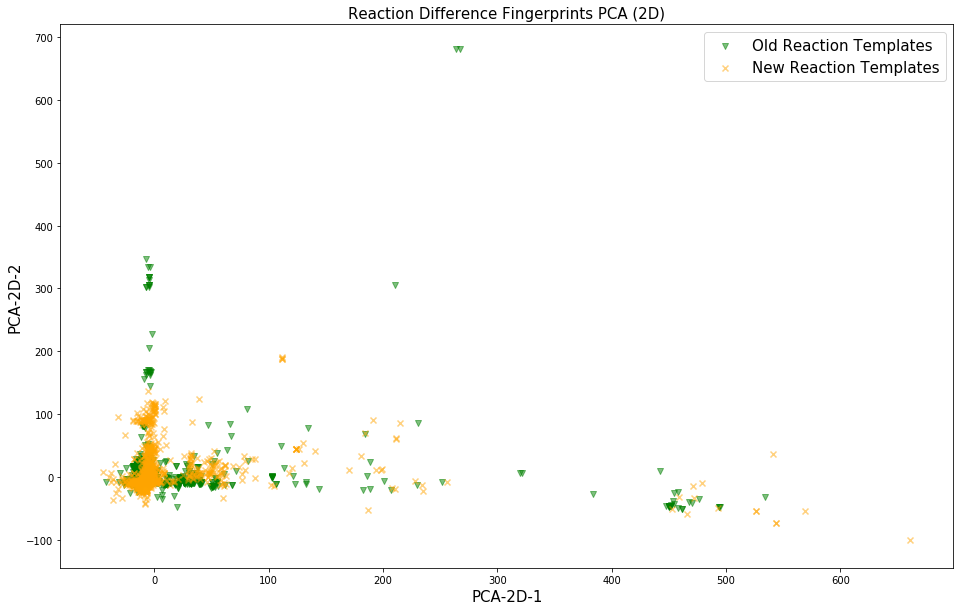

In [19]:
plt.figure(figsize=(16, 10))

plt.title("Reaction Difference Fingerprints PCA (2D)", fontsize=15)
plt.xlabel("PCA-2D-1", fontsize=15)
plt.ylabel("PCA-2D-2", fontsize=15)

sp_old = plt.scatter(x=pca_result_old[:,0],
                     y=pca_result_old[:,1],
                     marker="v",
                     c="green",
                     alpha=0.5)

sp_new = plt.scatter(x=pca_result_new[:,0],
                     y=pca_result_new[:,1],
                     marker="x",
                     c="orange",
                     alpha=0.5)

plt.legend((sp_old, sp_new), ("Old Reaction Templates", "New Reaction Templates"), fontsize=15);
plt.show()

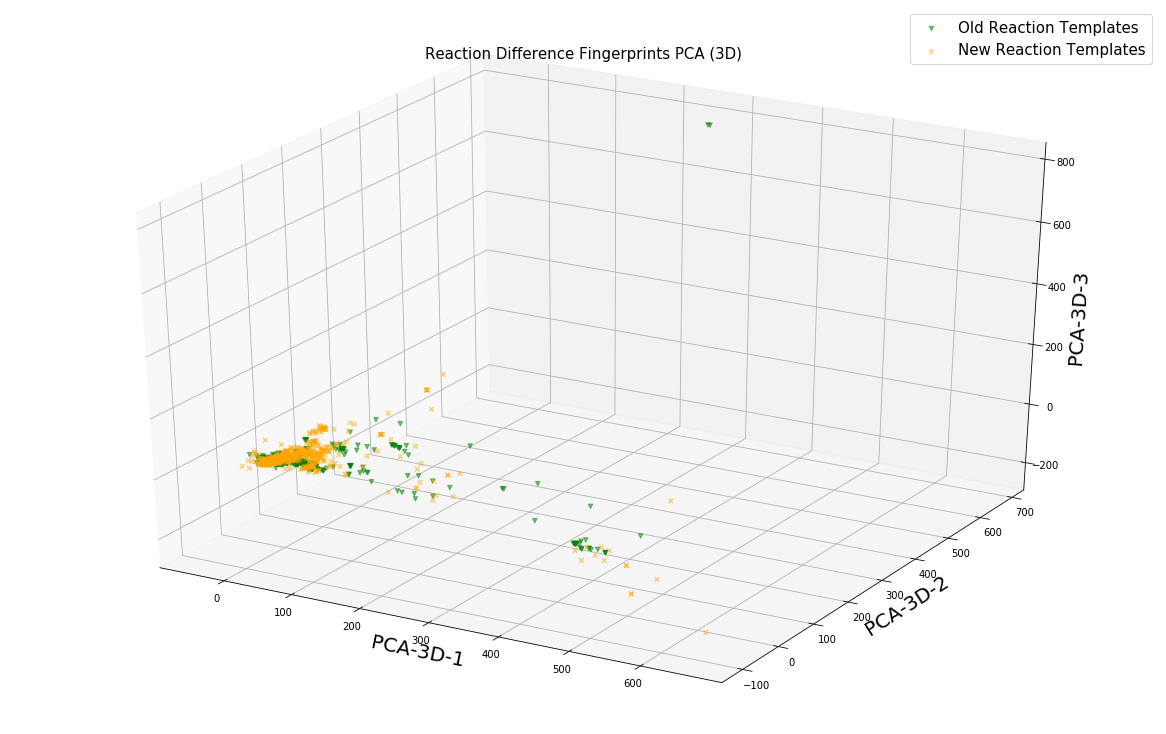

In [20]:
fig = plt.figure(figsize=(16,10))
ax = Axes3D(fig)

ax.set_title("Reaction Difference Fingerprints PCA (3D)", fontsize=15)
ax.set_xlabel("PCA-3D-1", fontsize=20)
ax.set_ylabel("PCA-3D-2", fontsize=20)
ax.set_zlabel("PCA-3D-3", fontsize=20)

sp_old = ax.scatter(pca_result_old[:,0], pca_result_old[:,1], pca_result_old[:,2], marker="v", c="green", alpha=0.5)
sp_new = ax.scatter(pca_result_new[:,0], pca_result_new[:,1], pca_result_new[:,2], marker="x", c="orange", alpha=0.5)

plt.legend((sp_old, sp_new), ("Old Reaction Templates", "New Reaction Templates"), fontsize=15);
plt.show()

In [21]:
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)

tsne_results_old = tsne.fit_transform(pca_result_old)
tsne_results_new = tsne.fit_transform(pca_result_new)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2056 samples in 0.007s...
[t-SNE] Computed neighbors for 2056 samples in 0.283s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2056
[t-SNE] Computed conditional probabilities for sample 2000 / 2056
[t-SNE] Computed conditional probabilities for sample 2056 / 2056
[t-SNE] Mean sigma: 11.766894
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.342888
[t-SNE] KL divergence after 300 iterations: 0.749081
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2477 samples in 0.008s...
[t-SNE] Computed neighbors for 2477 samples in 0.432s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2477
[t-SNE] Computed conditional probabilities for sample 2000 / 2477
[t-SNE] Computed conditional probabilities for sample 2477 / 2477
[t-SNE] Mean sigma: 8.188301
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.717659
[t-SNE] KL divergence after 300 iterations: 1.051971

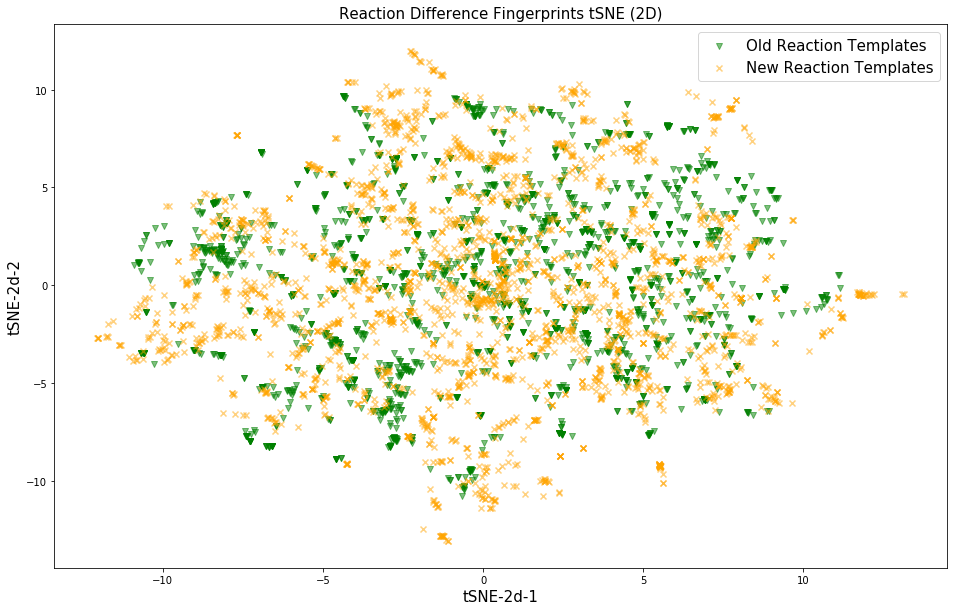

In [22]:
plt.figure(figsize=(16, 10))

plt.title("Reaction Difference Fingerprints tSNE (2D)", fontsize=15)
plt.xlabel("tSNE-2d-1", fontsize=15)
plt.ylabel("tSNE-2d-2", fontsize=15)

sp_old = plt.scatter(x=tsne_results_old[:,0],
                     y=tsne_results_old[:,1],
                     marker="v",
                     c="green",
                     alpha=0.5)

sp_new = plt.scatter(x=tsne_results_new[:,0],
                     y=tsne_results_new[:,1],
                     marker="x",
                     c="orange",
                     alpha=0.5)

plt.legend((sp_old, sp_new), ("Old Reaction Templates", "New Reaction Templates"), fontsize=15);
plt.show()

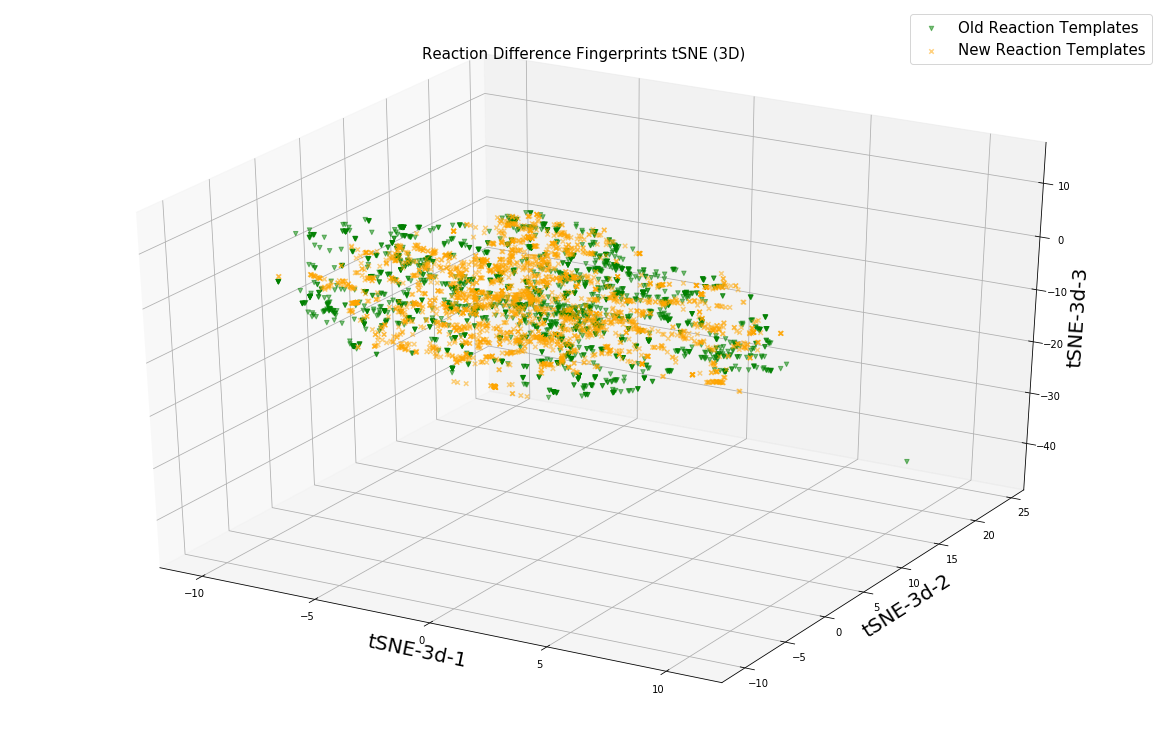

In [11]:
fig = plt.figure(figsize=(16,10))
ax = Axes3D(fig)

ax.set_title("Reaction Difference Fingerprints tSNE (3D)", fontsize=15)
ax.set_xlabel("tSNE-3d-1", fontsize=20)
ax.set_ylabel("tSNE-3d-2", fontsize=20)
ax.set_zlabel("tSNE-3d-3", fontsize=20)

sp_old = ax.scatter(tsne_results_old[:,0], tsne_results_old[:,1], tsne_results_old[:,2],
                    marker="v", c="green", alpha=0.5)
sp_new = ax.scatter(tsne_results_new[:,0], tsne_results_new[:,1], tsne_results_new[:,2],
                    marker="x", c="orange", alpha=0.5)

plt.legend((sp_old, sp_new), ("Old Reaction Templates", "New Reaction Templates"), fontsize=15);
plt.show()

In [12]:
old_templates_struct_fps = [generate_rxn_fp(x, "struct") for x in old_templates if x is not None]
new_templates_struct_fps = [generate_rxn_fp(x, "struct") for x in new_templates if x is not None]

pca_old = PCA(n_components=50)
pca_result_old = pca_old.fit_transform(old_templates_struct_fps)

pca_new = PCA(n_components=50)
pca_result_new = pca_new.fit_transform(new_templates_struct_fps)

print("Fraction of the overall variance represented by the first 50 principal components of the old templates: " 
      "{:.3f}".format(np.sum(pca_old.explained_variance_ratio_)))
print("Fraction of the overall variance represented by the first 50 principal components of the new templates: "
      "{:.3f}".format(np.sum(pca_new.explained_variance_ratio_)))

Fraction of the overall variance represented by the first 50 principal components of the old templates: 0.944
Fraction of the overall variance represented by the first 50 principal components of the new templates: 0.915


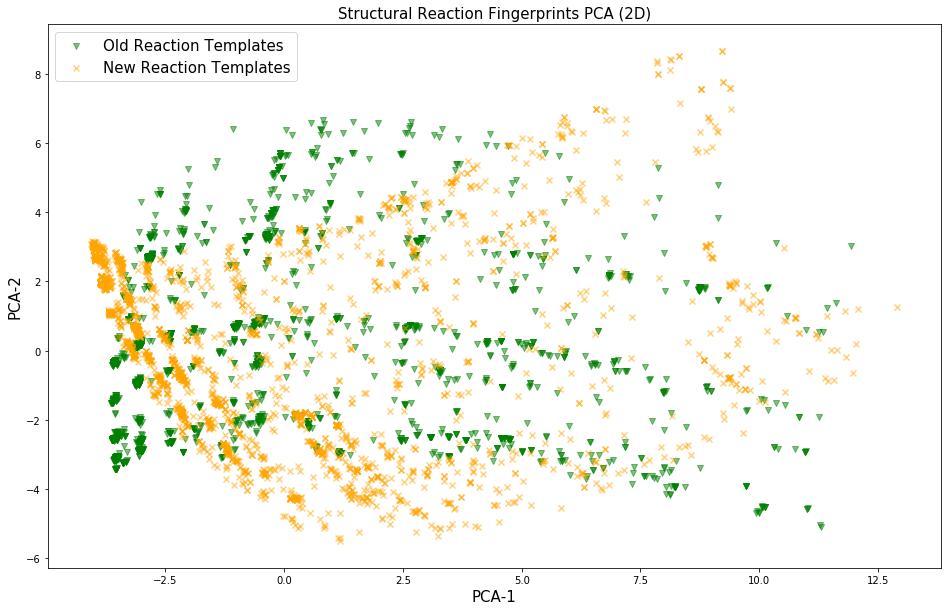

In [13]:
plt.figure(figsize=(16, 10))

plt.title("Structural Reaction Fingerprints PCA (2D)", fontsize=15)
plt.xlabel("PCA-1", fontsize=15)
plt.ylabel("PCA-2", fontsize=15)

sp_old = plt.scatter(x=pca_result_old[:,0],
                     y=pca_result_old[:,1],
                     marker="v",
                     c="green",
                     alpha=0.5)

sp_new = plt.scatter(x=pca_result_new[:,0],
                     y=pca_result_new[:,1],
                     marker="x",
                     c="orange",
                     alpha=0.5)

plt.legend((sp_old, sp_new), ("Old Reaction Templates", "New Reaction Templates"), fontsize=15);
plt.show()

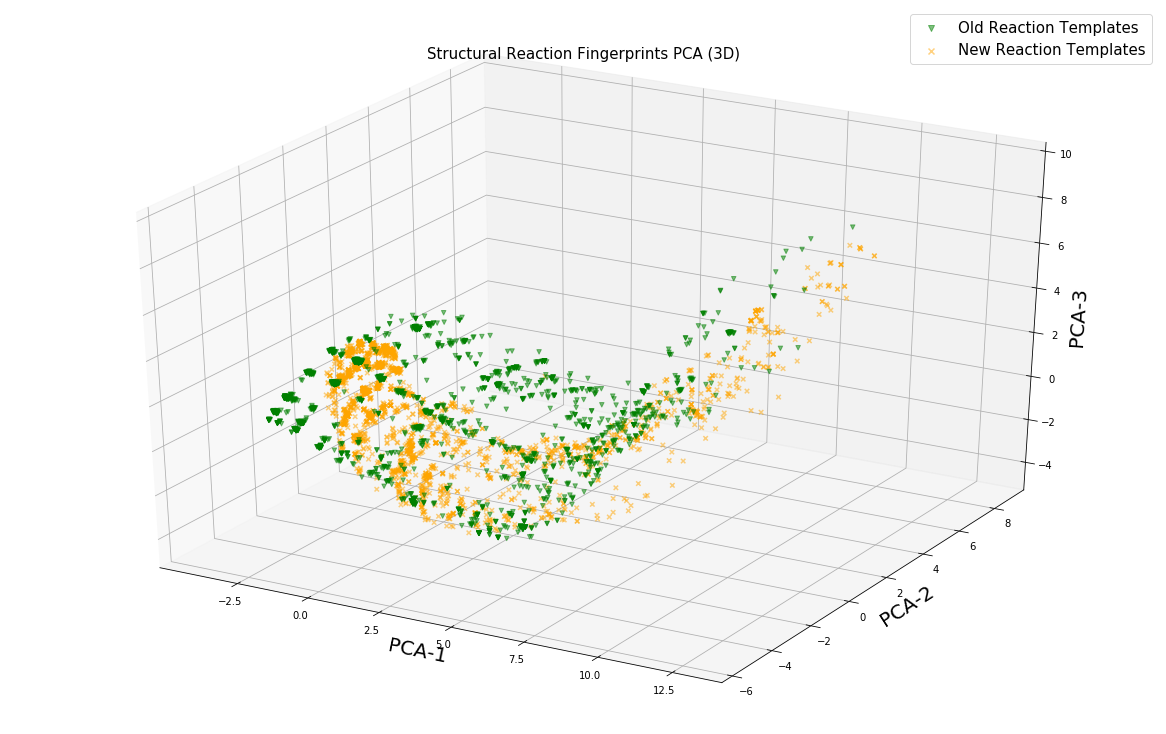

In [14]:
fig = plt.figure(figsize=(16,10))
ax = Axes3D(fig)

ax.set_title("Structural Reaction Fingerprints PCA (3D)", fontsize=15)
ax.set_xlabel("PCA-1", fontsize=20)
ax.set_ylabel("PCA-2", fontsize=20)
ax.set_zlabel("PCA-3", fontsize=20)

ax.scatter(pca_result_old[:,0], pca_result_old[:,1], pca_result_old[:,2], marker="v", c="green", alpha=0.5)
ax.scatter(pca_result_new[:,0], pca_result_new[:,1], pca_result_new[:,2], marker="x", c="orange", alpha=0.5)

plt.legend((sp_old, sp_new), ("Old Reaction Templates", "New Reaction Templates"), fontsize=15);
plt.show()

In [15]:
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)

tsne_results_old = tsne.fit_transform(pca_result_old)
tsne_results_new = tsne.fit_transform(pca_result_new)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2056 samples in 0.006s...
[t-SNE] Computed neighbors for 2056 samples in 0.173s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2056
[t-SNE] Computed conditional probabilities for sample 2000 / 2056
[t-SNE] Computed conditional probabilities for sample 2056 / 2056
[t-SNE] Mean sigma: 1.619402
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.162094
[t-SNE] KL divergence after 300 iterations: 0.496879
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2477 samples in 0.008s...
[t-SNE] Computed neighbors for 2477 samples in 0.307s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2477
[t-SNE] Computed conditional probabilities for sample 2000 / 2477
[t-SNE] Computed conditional probabilities for sample 2477 / 2477
[t-SNE] Mean sigma: 1.808306
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.693794
[t-SNE] KL divergence after 300 iterations: 0.667328


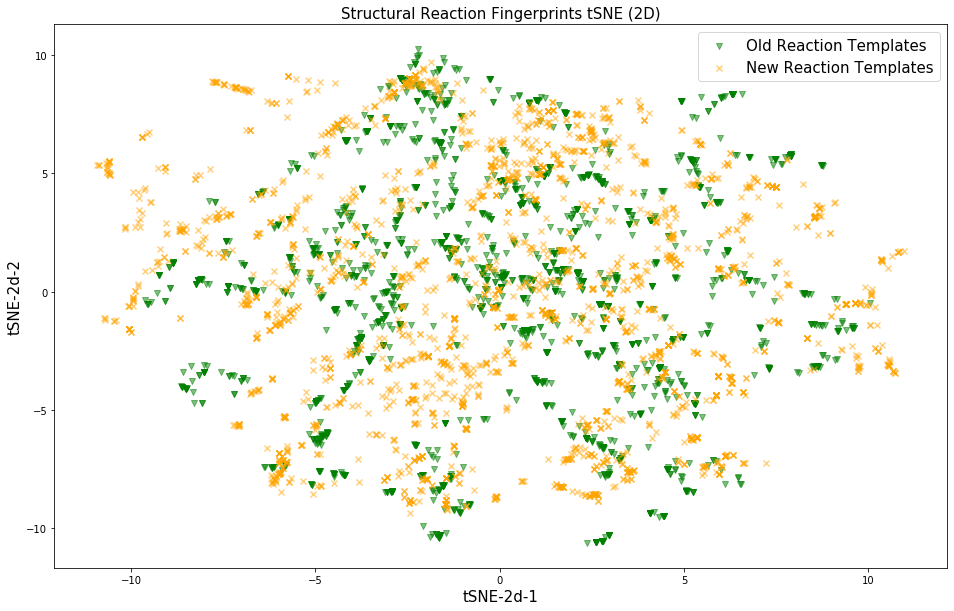

In [16]:
plt.figure(figsize=(16, 10))

plt.title("Structural Reaction Fingerprints tSNE (2D)", fontsize=15)
plt.xlabel("tSNE-2d-1", fontsize=15)
plt.ylabel("tSNE-2d-2", fontsize=15)

sp_old = plt.scatter(x=tsne_results_old[:,0],
                     y=tsne_results_old[:,1],
                     marker="v",
                     c="green",
                     alpha=0.5)

sp_new = plt.scatter(x=tsne_results_new[:,0],
                     y=tsne_results_new[:,1],
                     marker="x",
                     c="orange",
                     alpha=0.5)

plt.legend((sp_old, sp_new), ("Old Reaction Templates", "New Reaction Templates"), fontsize=15);
plt.show()

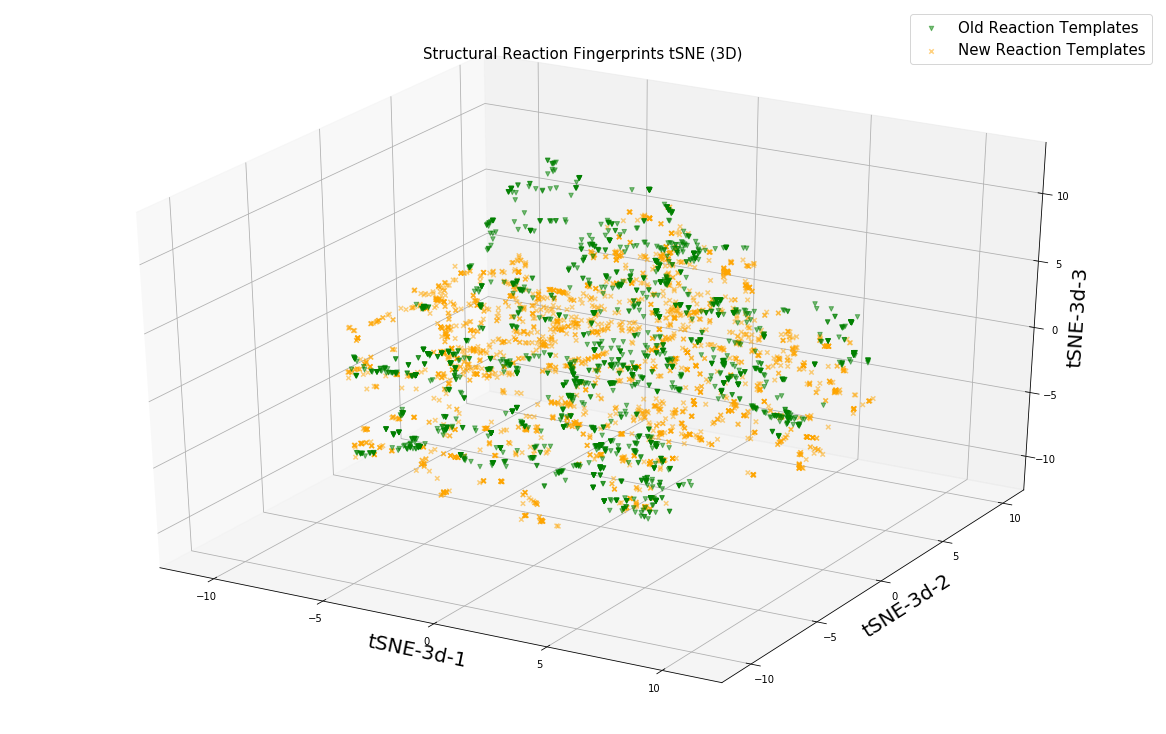

In [17]:
fig = plt.figure(figsize=(16,10))
ax = Axes3D(fig)

ax.set_title("Structural Reaction Fingerprints tSNE (3D)", fontsize=15)
ax.set_xlabel("tSNE-3d-1", fontsize=20)
ax.set_ylabel("tSNE-3d-2", fontsize=20)
ax.set_zlabel("tSNE-3d-3", fontsize=20)

sp_old = ax.scatter(tsne_results_old[:,0], tsne_results_old[:,1], tsne_results_old[:,2],
                    marker="v", c="green", alpha=0.5)
sp_new = ax.scatter(tsne_results_new[:,0], tsne_results_new[:,1], tsne_results_new[:,2],
                    marker="x", c="orange", alpha=0.5)

plt.legend((sp_old, sp_new), ("Old Reaction Templates", "New Reaction Templates"), fontsize=15);
plt.show()